# Libraries

In [8]:
import sys
sys.path.append("/Users/ktakeda/workspace/kaggle/rsna-breast-cancer-detection")

import os
import pandas as pd
import numpy as np
import cv2
import pathlib 
import torch
from torch.utils.data import DataLoader
import argparse
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm import tqdm

# local
from rsna.utility import load_data, data_to_device, dicom2png
from rsna.preprocess import Transform, df_preprocess
from rsna.model import ResNet50Network, EfficientNet
from rsna.config import DEVICE, PLATFORM
from rsna.dataset import RSNADatasetPNG

## 学習済みモデルの評価

- 2/7 時点で score 0.04 となった最新の学習済みモデルを評価する
    - そもそも train dataset に対して、性能が出ているのか？

In [3]:
# dataset, dataloader
df_train = load_data("train", custom_path="/Users/ktakeda/workspace/kaggle/rsna-breast-cancer-detection/data/dicom2png_512")
df_train = df_preprocess(df_train, is_train=True, sampling="down")
df_train_0 = df_train[df_train["cancer"]==0].reset_index(drop=True)
df_train_1 = df_train[df_train["cancer"]==1].reset_index(drop=True)
transform = Transform(cfg=None, only_test=True) 
dataset0 = RSNADatasetPNG(df_train_0, transform.get(is_train=False), csv_columns = ["laterality", "view", "age", "implant"], has_target=True)
dataset1 = RSNADatasetPNG(df_train_1, transform.get(is_train=False), csv_columns = ["laterality", "view", "age", "implant"], has_target=True)
loader0 = DataLoader(dataset0, batch_size=8, shuffle=False, num_workers=2)
loader1 = DataLoader(dataset1, batch_size=8, shuffle=False, num_workers=2)

# load trained model
model = EfficientNet(pretrained=False).to(DEVICE)
model.load_state_dict(torch.load(f"model_fold1_epoch49_vacc0.506_vpfbeta0.417.pth", map_location=torch.device(DEVICE)))
model.eval()

EfficientNet(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=

In [4]:
# predict
predict_true0, predict_true1 = [], []

#for idx, data in enumerate(dataset0):
#    if idx > 200: break
#    image = torch.unsqueeze(data["image"],1)
#    target = data["target"]
#    out = model(image, None)
#    pred = torch.sigmoid(out)
#
#    predict_true0.append(pred.squeeze(1).cpu().detach().numpy()[0])


for data in tqdm(loader1, total=len(loader1)):
    # image = torch.unsqueeze(data["image"],1)
    target = data["target"]
    out = model(data["image"], None)
    pred = torch.sigmoid(out)
    predict_true1.extend(list(pred.squeeze(1).cpu().detach().numpy()))

100%|██████████| 145/145 [04:43<00:00,  1.96s/it]


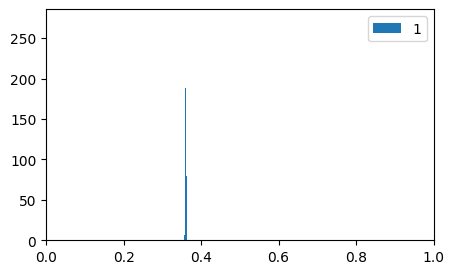

In [5]:
fig, ax = plt.subplots(figsize=(5,3))
# ax.hist(predict_true0, label="0")
ax.hist(predict_true1, label="1")
ax.set_xlim(0,1)
ax.legend()
plt.show()

In [11]:
a = np.where(np.array(predict_true1)>0.5,1,0)
a[a==1]

array([], dtype=int64)

- 全ての予測値が0.3 のスコアを持っていて、全く学習できていないことが分かる
  - cancer==0 に対しても 0.3 のスコアしか持っていなかった